In [47]:
! pip install --quiet "pandas" "torch>=1.6, <1.9" "torchvision" "ipython[notebook]" "seaborn" "pytorch-lightning>=1.4" "torchmetrics>=0.6" "lightning-bolts"


[notice] A new release of pip available: 22.3 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import os
import pandas as pd
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from IPython.core.display import display
from pytorch_lightning import LightningModule, Trainer, seed_everything
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.functional import accuracy, f1_score, auroc
from prep import CustomImageDataset
from torch.utils.data import DataLoader

seed_everything(7)

PATH_DATASETS = os.environ.get("PATH_DATASETS", ".")
NUM_WORKERS = int(os.cpu_count() / 2)

C:\Users\user\AppData\Local\Temp\ipykernel_7016\1506049270.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
Global seed set to 7


In [63]:
path_img = 'C:\\Users\\user\\OneDrive\\Рабочий стол\\Учебка\\images'
BATCH_SIZE = 32
train_label = "C:\\Users\\user\\Downloads\\train_data.csv"
test_label = "C:\\Users\\user\\Downloads\\test_data.csv"

train_set = CustomImageDataset(train_label,path_img,target_transform=True)
test_set = CustomImageDataset(test_label,path_img,target_transform=True)

train_data = DataLoader(train_set, batch_size=BATCH_SIZE)
test_data=DataLoader(test_set, batch_size=BATCH_SIZE)

In [80]:
def create_model():
    model = torchvision.models.resnet18(pretrained=True)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 4)
    model.maxpool = nn.Identity()
    return model

In [76]:
class LitResnet(LightningModule):
    def __init__(self, lr=0.05):
        super().__init__()
        self.save_hyperparameters()
        self.model = create_model()

    def forward(self, x):
        out = self.model(x)
        return F.log_softmax(out, dim=1)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log("train_loss", loss)
        return loss

    def evaluate(self, batch, stage=None):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, y, task="multiclass", num_classes=4)
        f1 = f1_score(preds, y, task="multiclass", num_classes=4)
        preds = torch.softmax(logits, dim=1)
        auc = auroc(preds, y, task="multiclass", num_classes=4)

        if stage:
            self.log(f"{stage}_loss", loss, prog_bar=True)
            self.log(f"{stage}_acc", acc, prog_bar=True)
            self.log(f"{stage}_f1", f1, prog_bar=True)
            self.log(f"{stage}_auc", auc, prog_bar=True)

    def validation_step(self, batch, batch_idx):
        self.evaluate(batch, "val")

    def test_step(self, batch, batch_idx):
        self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(
            self.parameters(),
            lr=self.hparams.lr,
            momentum=0.9,
            weight_decay=5e-4,
        )
        scheduler_dict = {
            "scheduler": OneCycleLR(
                optimizer,
                0.1,
                epochs=self.trainer.max_epochs,
                steps_per_epoch=len(train_data),
            ),
            "interval": "step",
        }
        return {"optimizer": optimizer, "lr_scheduler": scheduler_dict}

In [298]:
model = LitResnet(lr=0.05)

trainer = Trainer(
    max_epochs=100,
    accelerator="auto",
    devices=1 if torch.cuda.is_available() else None,  # limiting got iPython runs
    logger=CSVLogger(save_dir="logs/"),
    callbacks=[LearningRateMonitor(logging_interval="step"), TQDMProgressBar(refresh_rate=1)],
)

#trainer.fit(model, train_data)
#trainer.test(model, test_data)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


,lr-SGD,train_loss,test_loss,test_acc,test_f1,test_auc
epoch,,,,,,
NaN,0.004516,NaN,NaN,NaN,NaN,NaN
1.0,NaN,1.190647,NaN,NaN,NaN,NaN
NaN,0.006094,NaN,NaN,NaN,NaN,NaN
2.0,NaN,1.352146,NaN,NaN,NaN,NaN
NaN,0.008700,NaN,NaN,NaN,NaN,NaN


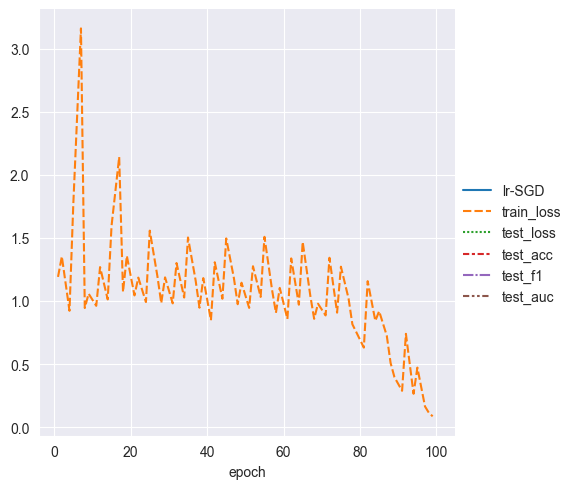

In [306]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")
del metrics["step"]
metrics.set_index("epoch", inplace=True)
display(metrics.dropna(axis=1, how="all").head())
sn.relplot(data=metrics, kind="line")

In [289]:
# Specify a path
from torchvision import transforms
PATH = "m4.pt"
# Save
torch.save(model, PATH)
# Load
model = torch.load(PATH)
model.eval()

LitResnet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): Identity()
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (con

In [290]:
inputs, classes = next(iter(train_data))
outputs=model(inputs)
_, preds = torch.max(outputs, 1)
preds=preds.cpu().numpy()
classes=classes.numpy()
print(preds)
print(classes)

[0 0 0 1 0 2 2 2 0 0 0 2 1 0 1 0 0 2 2 1 1 0 0 2 0 0 1 1 0 0 0 0]
[0 0 0 1 2 2 2 2 0 0 0 2 1 0 1 0 0 2 2 1 1 0 0 2 0 0 1 1 0 0 0 2]


In [291]:
import io
def transform_image(image_bytes):
    my_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.CenterCrop(128),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0., ], [1.])])
    image = Image.open(io.BytesIO(image_bytes)).convert("RGB")
    return my_transforms(image).unsqueeze(0)

0  at confidence score:0.34


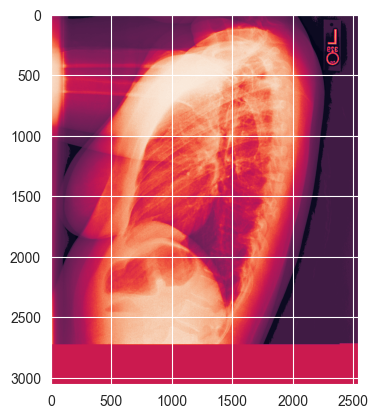

In [292]:
#блок с тестовым предсказанием перед gui
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes)
    output = model.forward(tensor)

    probs = torch.nn.functional.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), classes.item()

image_path="C:\\Users\\user\\Downloads\\0b04aedf-affc7615-7e08c29a-115db700-81e005da.jpg"
image = plt.imread(image_path)
plt.imshow(image)

with open(image_path, 'rb') as f:
    image_bytes = f.read()

    conf,y_pre=get_prediction(image_bytes=image_bytes)
    print(y_pre, ' at confidence score:{0:.2f}'.format(conf))

In [299]:
import tkinter as tk
from tkinter import ttk, filedialog
from PIL import Image, ImageTk, ImageFilter, ImageEnhance

# Загрузка нужной модели из пути файла
PATH = "m3.pt"
model = torch.load(PATH)
model.eval()

# Функция дял предсказания
def get_prediction(image_bytes):
    tensor = transform_image(image_bytes)
    output = model.forward(tensor)

    probs = F.softmax(output, dim=1)
    conf, classes = torch.max(probs, 1)
    return conf.item(), classes.item()

# Функция для загрузки изображения и получения предсказания
def process_image():
    global file_path
    file_path = filedialog.askopenfilename()
    if file_path:
        image = Image.open(file_path)
        image.thumbnail((500, 500))  # установка размеров
        image = ImageTk.PhotoImage(image)
        image_label.config(image=image)
        image_label.image = image

        with open(file_path, 'rb') as f:
            image_bytes = f.read()

            conf, y_pre = get_prediction(image_bytes=image_bytes)
            result_label.config(text=f"Prediction: {y_pre} ")

# увеличение яркости
def increase_brightness():
    image = file_path
    if image:
        pil_image = Image.open(image)  # создаем PIL изображение
        enhancer = ImageEnhance.Brightness(pil_image)
        pil_image = enhancer.enhance(1.5)  # Уровень яркости
        pil_image.thumbnail((500, 500))
        image = ImageTk.PhotoImage(pil_image)
        image_label.config(image=image)
        image_label.image = image

# понижение яркости
def decrease_brightness():
    image = file_path
    if image:
        pil_image = Image.open(image)
        enhancer = ImageEnhance.Brightness(pil_image)
        pil_image = enhancer.enhance(0.5)
        pil_image.thumbnail((500, 500))
        image = ImageTk.PhotoImage(pil_image)
        image_label.config(image=image)
        image_label.image = image

# Удаление гауссова шума
def remove_noise():
    image = file_path
    if image:
        pil_image = Image.open(image)
        pil_image = pil_image.filter(ImageFilter.GaussianBlur(2))
        pil_image.thumbnail((500, 500))
        image = ImageTk.PhotoImage(pil_image)
        image_label.config(image=image)
        image_label.image = image

# Собель
def apply_sobel_filter():
    image = file_path
    if image:
        pil_image = Image.open(image)
        pil_image = pil_image.filter(ImageFilter.FIND_EDGES)
        pil_image.thumbnail((500, 500))
        image = ImageTk.PhotoImage(pil_image)
        image_label.config(image=image)
        image_label.image = image
#вернуться к исходному изображению
def reset_image():
    image = file_path
    if image:
        pil_image = Image.open(image)
        pil_image.thumbnail((500, 500))
        image = ImageTk.PhotoImage(pil_image)
        image_label.config(image=image)
        image_label.image = image

# сохранить изображение
def save_image():
    image = file_path
    if image:
        pil_image = Image.open(image)
        file_save = filedialog.asksaveasfilename(defaultextension=".jpg", filetypes=[("JPEG", "*.jpg"), ("PNG", "*.png")])
        if file_path:
            pil_image.save(file_save)

# Создание окна
root = tk.Tk()
root.title("Image Prediction GUI")

# Размеры
root.geometry("400x450")
root.resizable(width=0, height=0)

# Стиль
style = ttk.Style()
style.theme_use('clam')

# Создание вкладок
notebook = ttk.Notebook(root, width=800, height=450)
notebook.pack()

prediction_frame = ttk.Frame(notebook, padding=10)
notebook.add(prediction_frame, text="Image Prediction")

# Кнопка для загрузки изображения
browse_button = ttk.Button(prediction_frame, text="Browse Image", command=process_image)
browse_button.pack(pady=10)

# Лейбл для отображения изображения
image_label = ttk.Label(prediction_frame)
image_label.pack()

# Предсказание
result_label = ttk.Label(prediction_frame, text="", font=("Helvetica", 14))
result_label.pack(pady=10)

#Трансформация изображения
transform_frame = ttk.Frame(notebook, padding=10)
notebook.add(transform_frame, text="Image Transformation")

model_frame = ttk.Frame(notebook, padding=20)
notebook.add(model_frame, text="Model Information")

model_info_label = ttk.Label(model_frame, text="Model Architecture: ResNet-18 (Input 128x128)\nThe first and the last layer was changed for this task\n\nModel Parameters: \noptimizer-SGD(lr=0.05), \nepoch-100,\ndata-MIMIC-CHR-JPG \n\nClasses: \nno edema - 0\nvascular congestion - 1\ninterstitial edema - 2\nalveolar edema - 3", font=("Arial", 10))
model_info_label.pack(padx=20, pady=20)
# Выбор функция для изображения
transform_options = ttk.Combobox(transform_frame, values=["Increase Brightness", "Decrease Brightness", "Remove Gaussian Noise", "Apply Sobel Filter"])
transform_options.set("Select Transformation")
transform_options.pack(pady=10)

transform_button = ttk.Button(transform_frame, text="Apply Transformation", command=lambda: apply_transformation(transform_options.get()))
transform_button.pack(pady=5)

reset_button = ttk.Button(transform_frame, text="Reset Image", command=reset_image)
reset_button.pack(pady=5)

save_button = ttk.Button(transform_frame, text="Save Image", command=save_image)
save_button.pack(pady=5)

def apply_transformation(option):
    if option == "Increase Brightness":
        increase_brightness()
    elif option == "Decrease Brightness":
        decrease_brightness()
    elif option == "Remove Gaussian Noise":
        remove_noise()
    elif option == "Apply Sobel Filter":
        apply_sobel_filter()

root.mainloop()